In [1]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(ggplot2, warn.conflicts = FALSE)
library(tsibble, warn.conflicts = FALSE)
library(stars, warn.conflicts = FALSE)
library(zeallot, warn.conflicts = FALSE)
library(tidyr, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)

options(repr.plot.width = 9, repr.plot.res = 300)

source("notebooks/integrazioni_regionali/nb_tools/state_avail.R")
source("src/load/load.R")
source("src/analysis/data/clim_availability.R")
source("src/pairing/analysis.R")
source("src/pairing/matching.R")
source("src/plot/plot_helpers.R")

first_date <- as.Date("2000-01-01")
last_date <- as.Date("2023-06-30")
dem <- read_stars("temp/dem/dem30.tif")


Caricamento del pacchetto richiesto: abind

Caricamento del pacchetto richiesto: sf

Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE

terra 1.7.55



In [2]:
stations.scia <- open.dataset("SCIA", "metadata") |>
    collect() |>
    st_md_to_sf() |>
    prepare_metadata(dem)
stations.dpc <- open.dataset("BRUN", "metadata") |>
    filter(flavor == "qc_era5") |>
    collect() |>
    st_md_to_sf() |>
    prepare_metadata(dem)

matches <- matches_table(stations.scia, stations.dpc)


In [3]:
matches |>
    filter(variable == "T_MAX") |>
    nrow()


[1] 6531

In [4]:
c(c(s.scia.tmax, s.scia.tmin), c(s.scia.tmax.means, s.scia.tmin.means)) %<-% (open.dataset("SCIA", "data") |>
    prepare_dss(matches, identifier.x, uint32()))

c(c(s.dpc.tmax, s.dpc.tmin), c(s.dpc.tmax.means, s.dpc.tmin.means)) %<-% (open.dataset("BRUN", "data") |>
    filter(flavor == "qc_era5") |>
    select(-flavor) |>
    prepare_dss(matches, identifier.y, utf8()))


In [5]:
analysis.tmin <- analyze_matches.wide(
    matches |> filter(variable == "T_MIN"),
    s.scia.tmin,
    s.dpc.tmin,
    s.scia.tmin.means,
    s.dpc.tmin.means
)


Warning message:
"There was 1 warning in `mutate()`.
i In argument: `Tinfo = Tinfo.numeric(...)`.
i In row 6409.
Caused by warning in `cor()`:
! la deviazione standard `e zero"


In [6]:
analysis.tmax <- analyze_matches.wide(
    matches |> filter(variable == "T_MAX"),
    s.scia.tmax,
    s.dpc.tmax,
    s.scia.tmax.means,
    s.dpc.tmax.means
)


Warning message:
"There was 1 warning in `mutate()`.
i In argument: `Tinfo = Tinfo.numeric(...)`.
i In row 6405.
Caused by warning in `cor()`:
! la deviazione standard `e zero"


In [7]:
analysis <- bind_rows(
    T_MIN = analysis.tmin,
    T_MAX = analysis.tmax,
    .id = "variable"
)


In [8]:
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2455242,131.2,6633165,354.3,NA,6633165,354.3
Vcells,118749765,906.0,358333681,2733.9,16384,559896376,4271.7


In [9]:
sensible_columns <- function(table, ...) {
    select(table, variable, identifier.x, starts_with("anagrafica"), version, distance, strSym, f0, fsemiside, starts_with("del"), ends_with("T"), ends_with("lap"), valid_days_both, ...)
}


## Selezione match "certi"
- stessa posizione;
- vicini e stesso user_code;
- delT < 0.05 & minilap > 0.95;

In [52]:
joined.pos <- filter(analysis, distance <= 100)
joined.user_code <- filter(analysis, user_code.x == user_code.y)
joined.T <- filter(analysis, delT < 0.05, minilap > 0.95)


In [53]:
analysis |>
    filter(delT < 0.05 & minilap > 0.95) |>
    sensible_columns() |>
    arrange(fsemiside) |>
    slice_head(n = 5)


variable,identifier.x,anagrafica.x,anagrafica.y,version,distance,strSym,f0,fsemiside,delH,delZ,delT,sdT,corT,climatdelT,climatsdT,overlap,minilap,valid_days_both
<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
T_MAX,7303,LUSERNA S. GIOVANNI,LUSERNA_S_GIOVANNI,NA,1.357566e+02,1.0000000,0.8988920,0.8988920,13,30.38092,0.04301939,0.1438006,0.9998486,0.67649341,0.39248646,0.5294803,0.9972376,3610
T_MIN,5688,Villanova (Borca di Cadore),VILLANOVA_BORCA_DI_CADORE,NA,2.638023e+00,1.0000000,0.9044477,0.9044477,7,0.00000,0.04272139,0.1374075,0.9997988,0.07781118,0.05189841,0.9103938,0.9996042,7577
T_MIN,12354,Sarentino,SARNTHEIN,NA,1.042235e+02,0.8634259,0.9209846,0.9212566,6,0.00000,0.03844689,0.1380146,0.9997960,0.10705388,0.06995846,0.8778839,1.0000000,7353
T_MAX,12337,Colma-Barbiano,KOLLMANN_BARBIAN,NA,1.042848e+02,0.7537685,0.8748449,0.9291523,21,0.00000,0.04170917,0.1842349,0.9997758,0.05749660,0.04894308,0.8879049,1.0000000,7255
T_MIN,6784,PERUGIA,NA,NA,1.878589e-03,NA,0.9355614,0.9383265,0,0.00000,0.01483532,0.1831712,0.9996095,0.02507829,0.02461273,0.9729667,0.9961677,8318


In [37]:
stations.scia |> filter(variable == "T_MIN", str_detect(anagrafica, "Anterselva"))


Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



,valid_days,identifier,net_code,user_code,elevation,state,province,anagrafica,rete,first_date,last_date,variable,geometry
,<int>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<date>,<date>,<chr>,<POINT [arc_degree]>
1,23282,12292,15,2147600BM,1274,Trentino-Alto Adige,Bolzano,Anterselva di Mezzo Osservatore,Idrografica,1956-01-01,2021-12-31,T_MIN,POINT (12.1009 46.86072)


In [38]:
stations.dpc |> filter(variable == "T_MIN", str_detect(anagrafica, "ANTHOLZ"))


,region_,country,anagrafica,GSOD,user_code,MG,identifier,elevation,province,version,internal_id,state,dpc,flavor,variable,geometry
,<fct>,<fct>,<chr>,<lgl>,<chr>,<lgl>,<chr>,<dbl>,<fct>,<int>,<int>,<chr>,<lgl>,<chr>,<chr>,<POINT [arc_degree]>
1,ita,IT,ANTHOLZ_MITTERTAL,FALSE,47600BM,FALSE,TMND_ITA_TAA_BZ_ANTHOLZ_MITTERTAL_47600BM,1236,BZ,NA,NA,Trentino-Alto Adige,FALSE,qc_era5,T_MIN,POINT (12.1007 46.8598)


In [54]:
alljoined <- bind_rows(
    joined.pos,
    joined.T,
    joined.user_code
) |> distinct()


In [55]:
useful_data <- analysis |>
    drop_na(distance, strSym, delZ, climatdelT, climatsdT, minilap, f0, fsemiside, valid_days_both)

comp_matrix <- useful_data |>
    select(distance, strSym, delZ, climatdelT, climatsdT, minilap, f0, fsemiside, valid_days_both) |>
    mutate(across(everything(), ~ as.vector(scale(.))))


In [56]:
nrow(analysis |> drop_na(f0))


[1] 11005

In [57]:
nrow(analysis)


[1] 13040

In [58]:
km <- stats::kmeans(comp_matrix, centers = 2, nstart = 100L, iter.max = 100L)
hc <- stats::hclust(dist(comp_matrix))


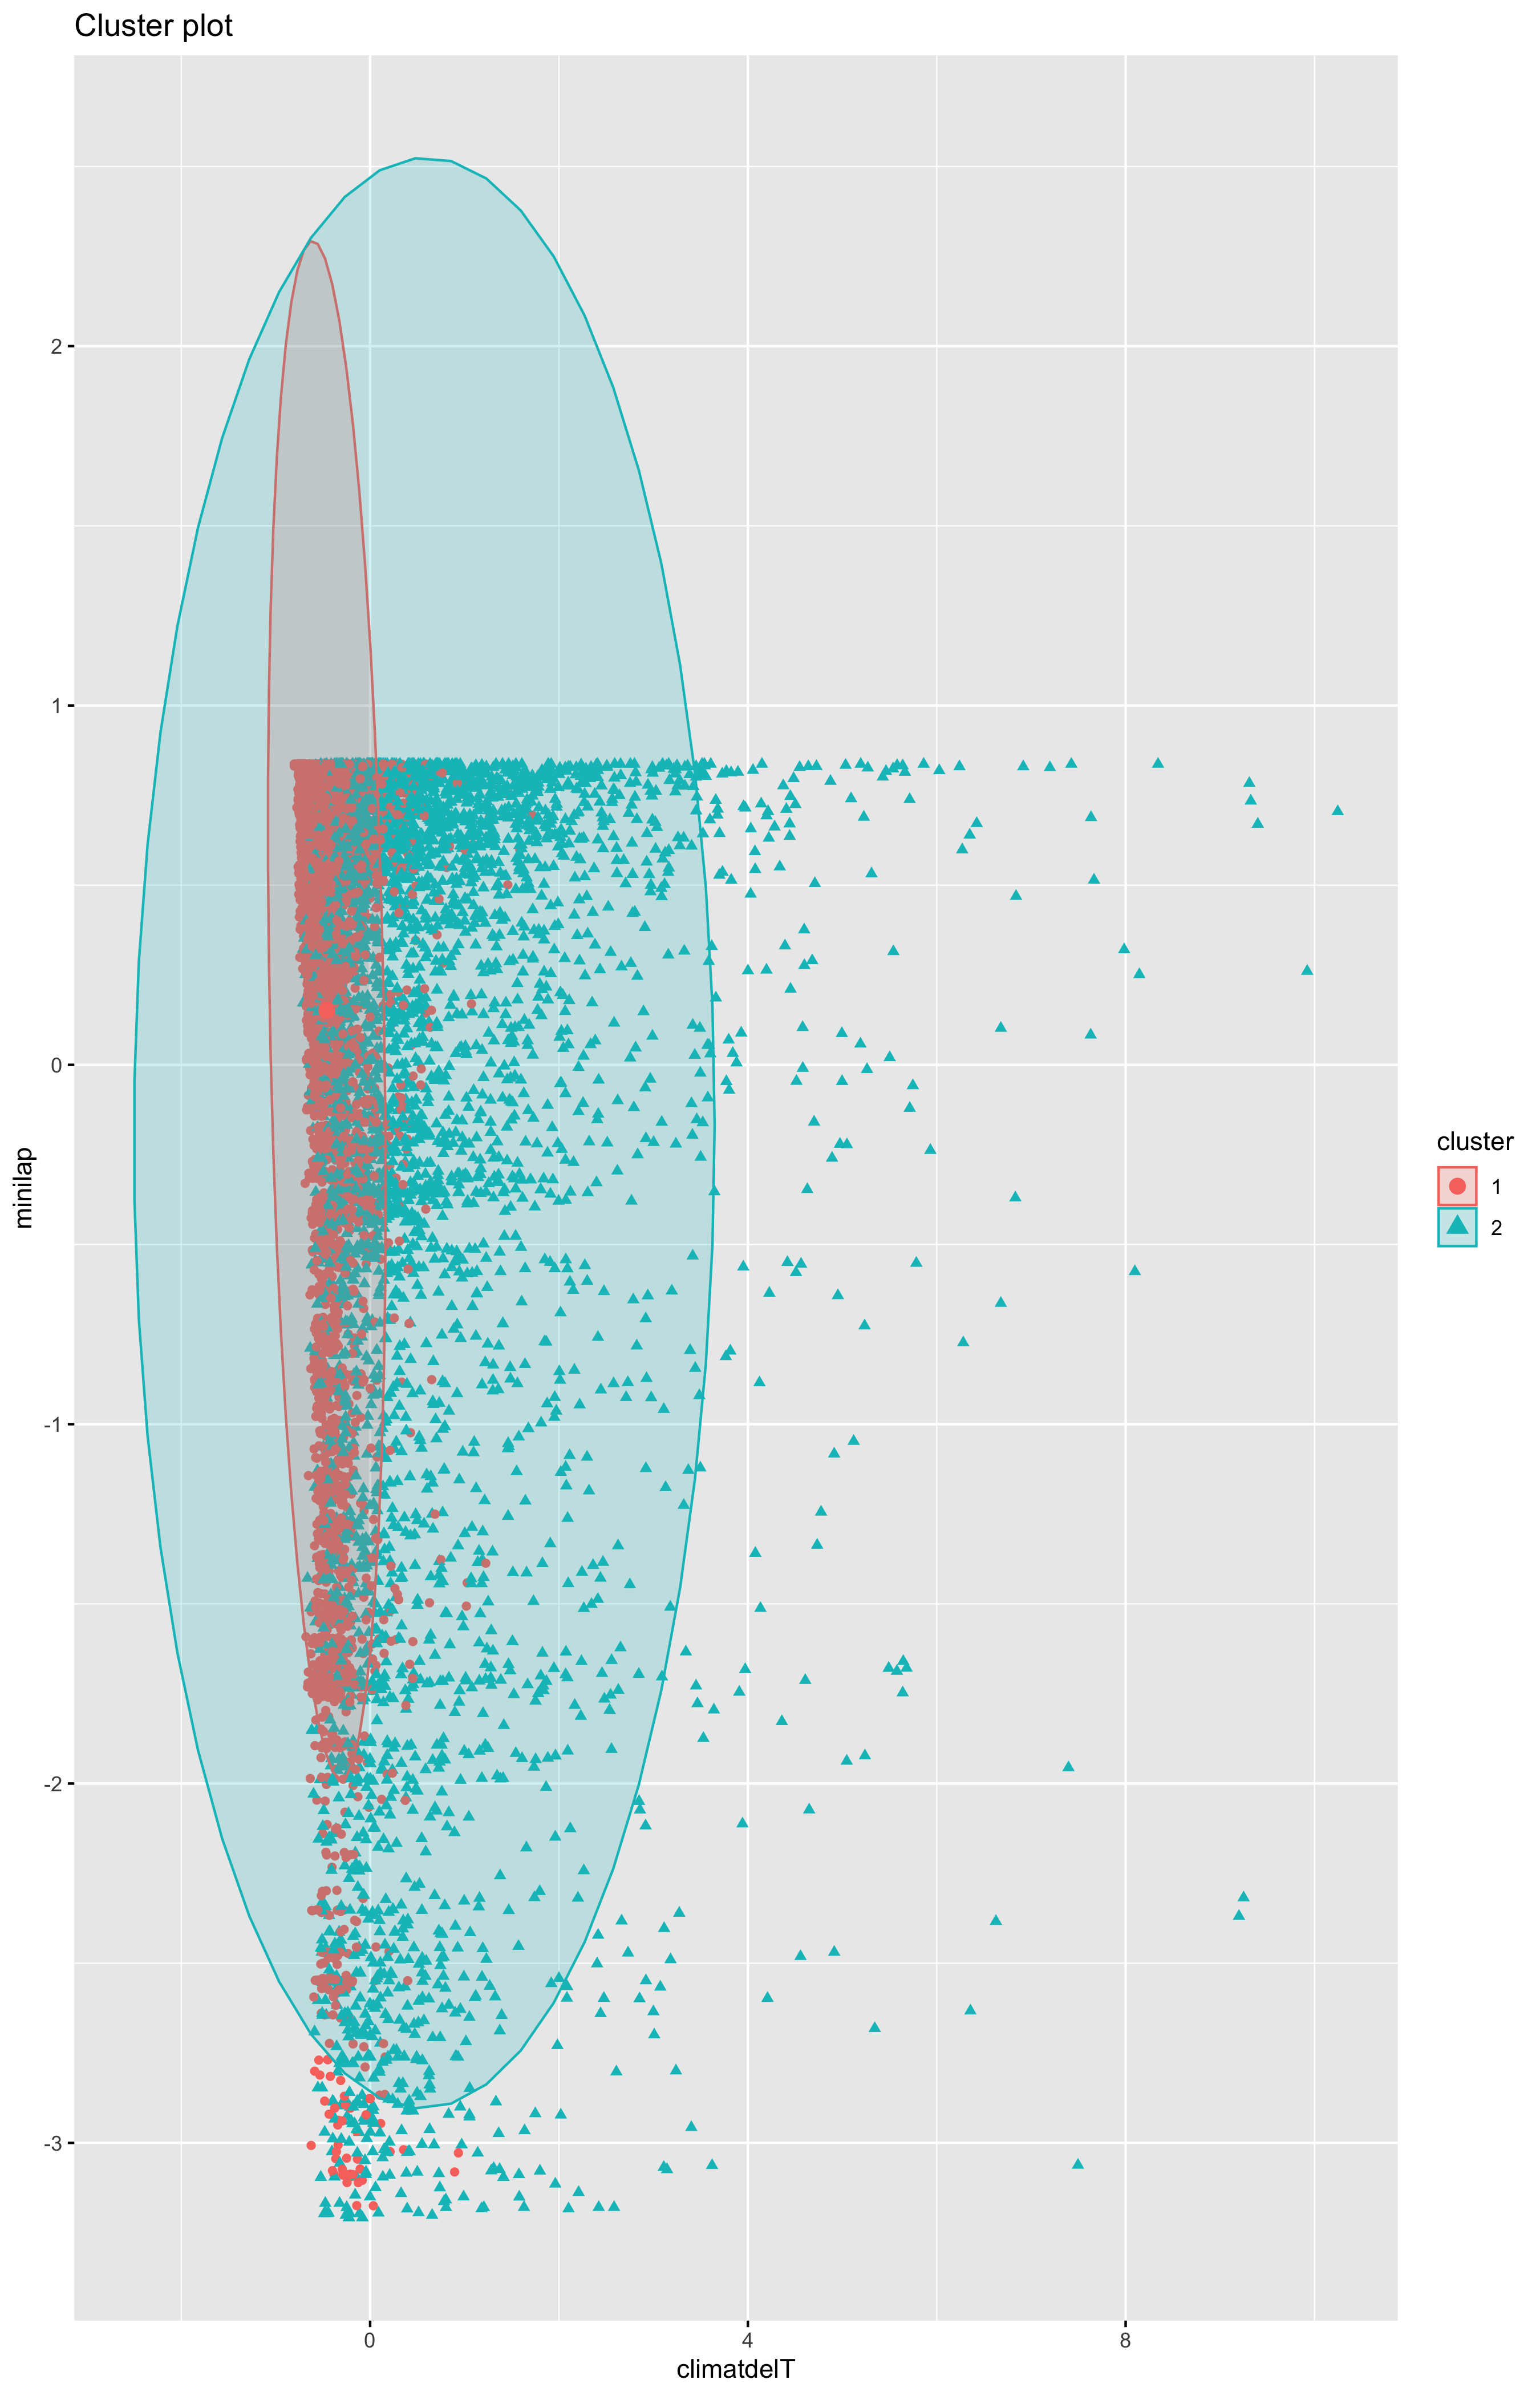

In [59]:
library(factoextra, warn.conflicts = FALSE)
fviz_cluster(km, data = comp_matrix, choose.vars = c("climatdelT", "minilap"), geom = "point", centroids = TRUE, repel = TRUE, ellipse.type = "norm")


In [60]:
training_set <- useful_data |> add_column(class = factor(km$cluster, levels = c(1, 2), labels = c("good", "bad")))


In [ ]:
training_set |>
    filter(class == "bad") |>
    select(variable, starts_with("identifier"), anagrafica.x, delT, climatdelT, sdT, f0, fsemiside)


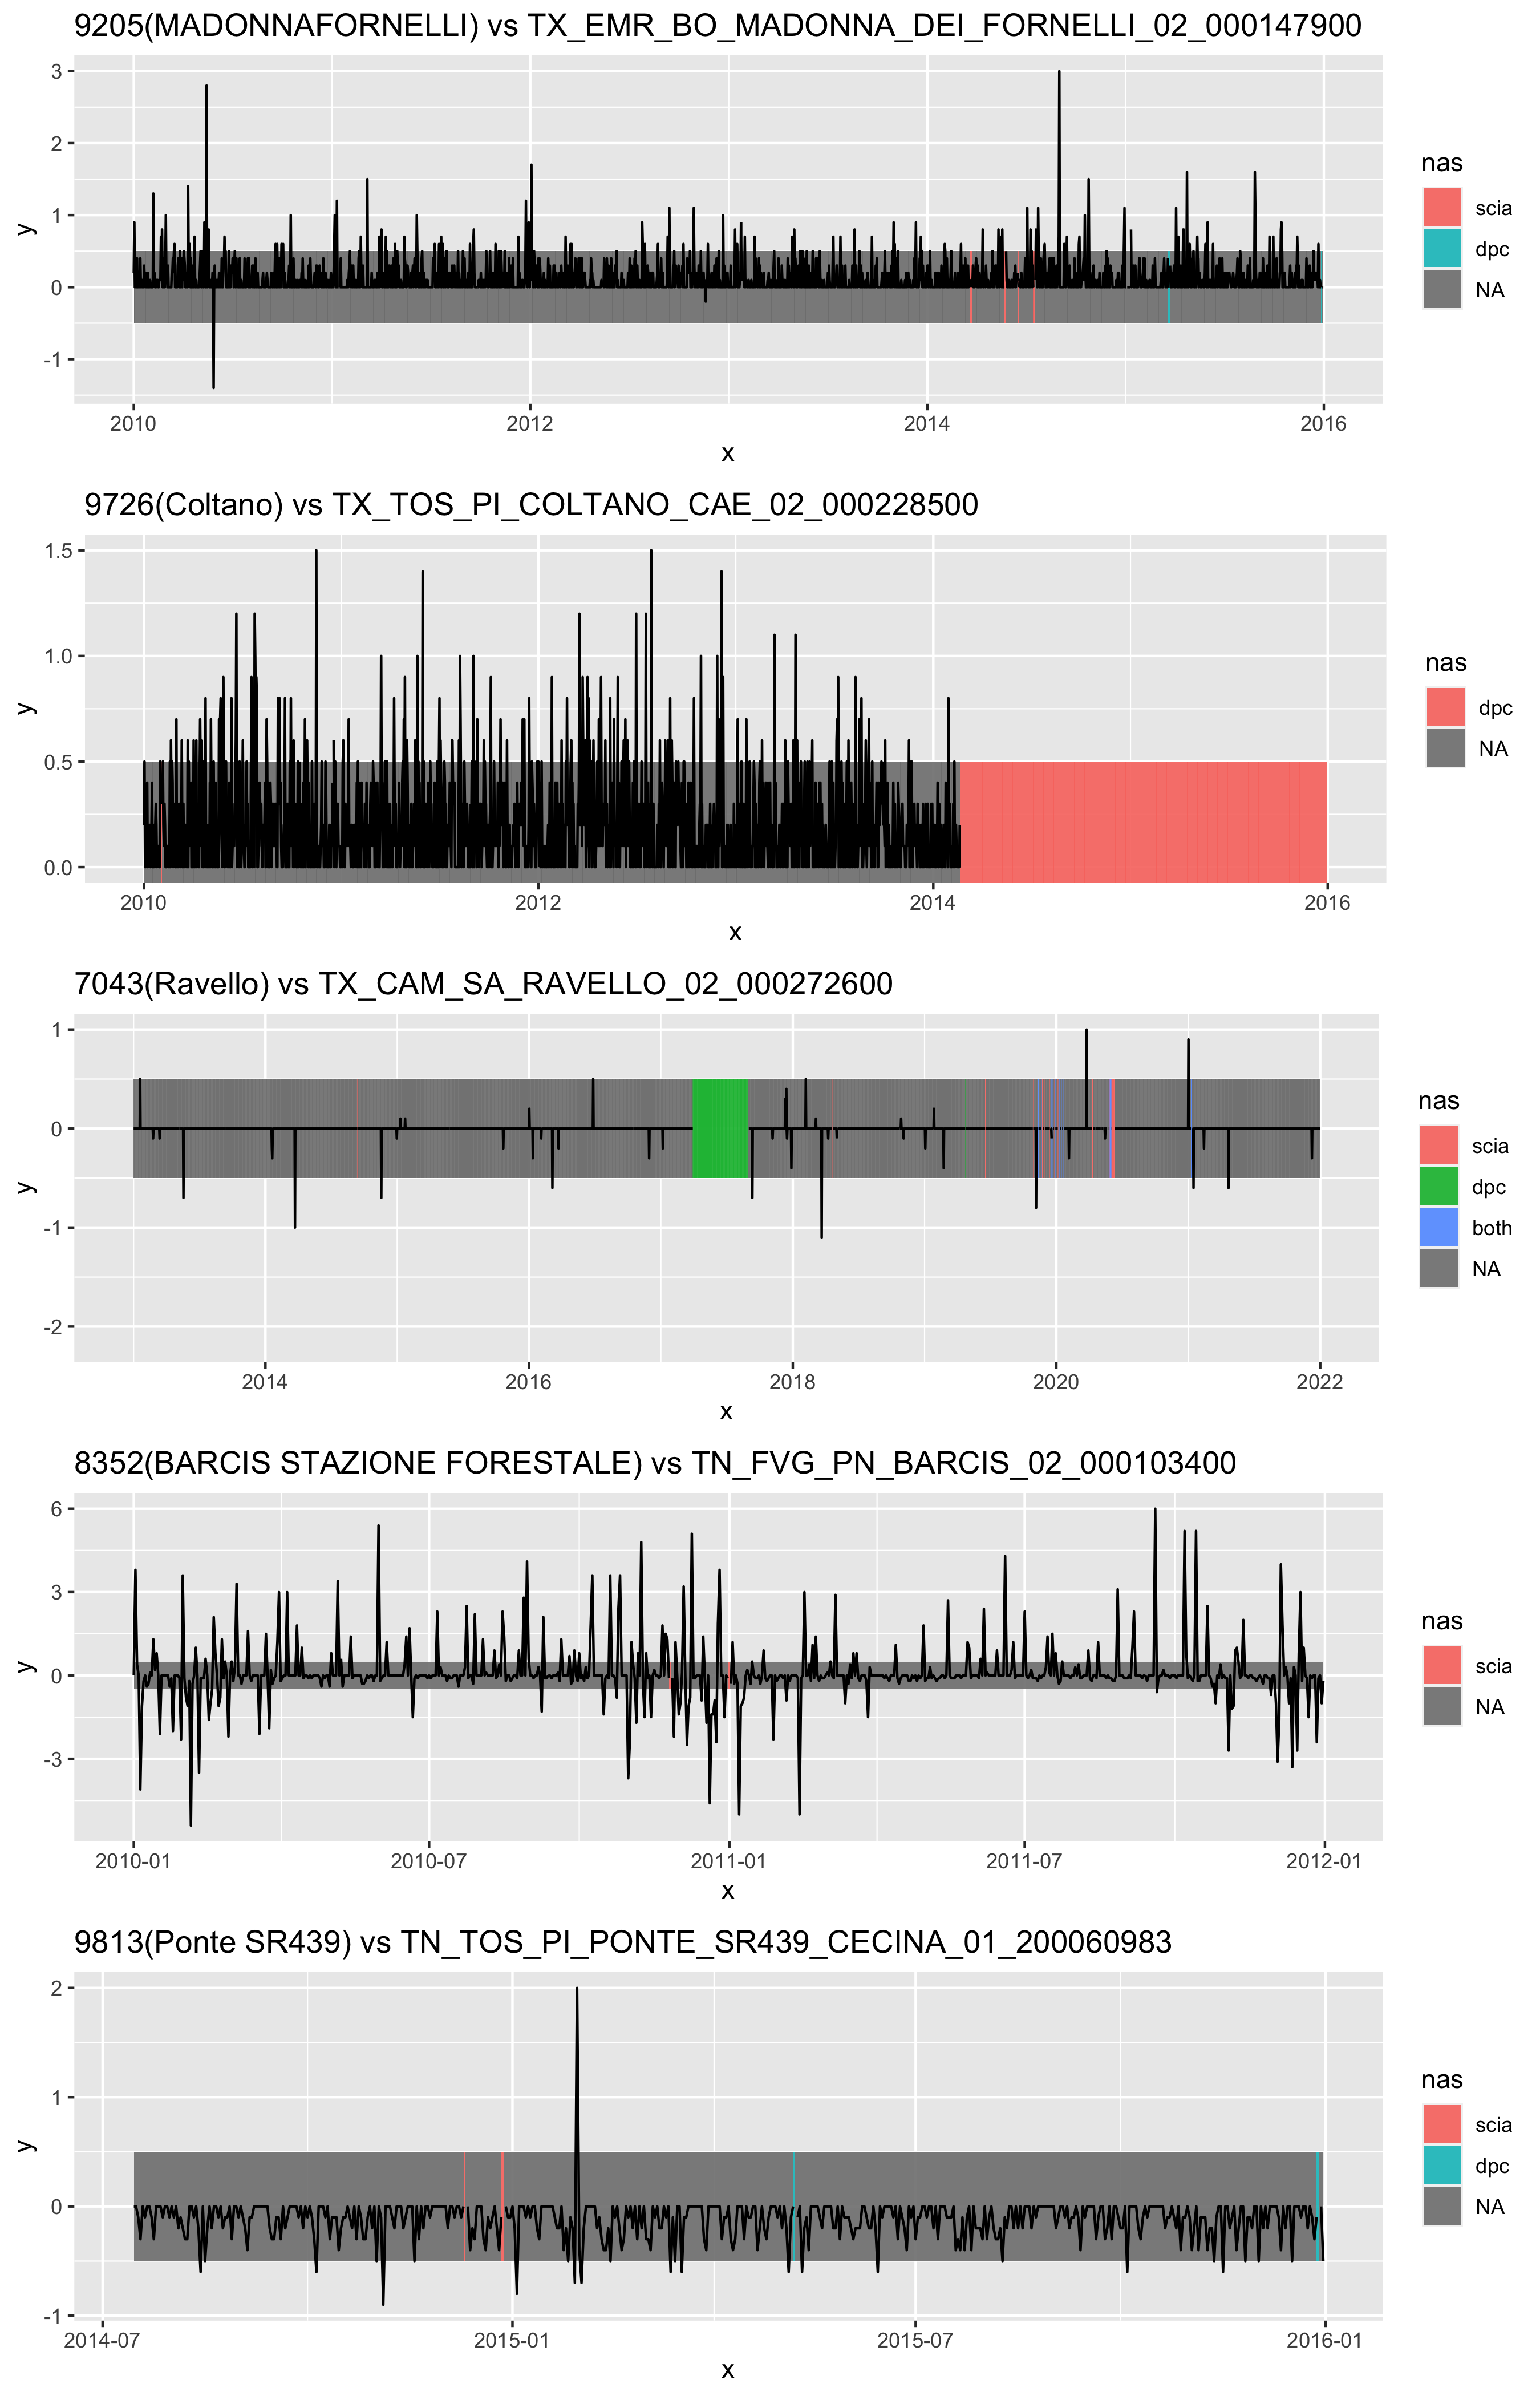

In [62]:
options(repr.plot.height = 14, repr.plot.res = 300)

plots <- training_set |>
    filter(class == "good") |>
    sample_n(size = 5) |>
    select(variable, starts_with("identifier"), anagrafica.x) |>
    rowwise() |>
    group_map(~ plot.sciavsdpc(.x[["variable"]], .x[["identifier.x"]], .x[["identifier.y"]], "qc_era5", start_date = "2010-01-01", anagrafica.scia = .x[["anagrafica.x"]]))
# plot.sciavsdpc("T_MIN", 7158, "TN_LIG_GE_ALPE_GORRETO_02_000297900", "qc_era5", start_date = "2022-01-01")
library(ggpubr, warn.conflicts = FALSE)
ggarrange(plotlist = plots, ncol = 1)


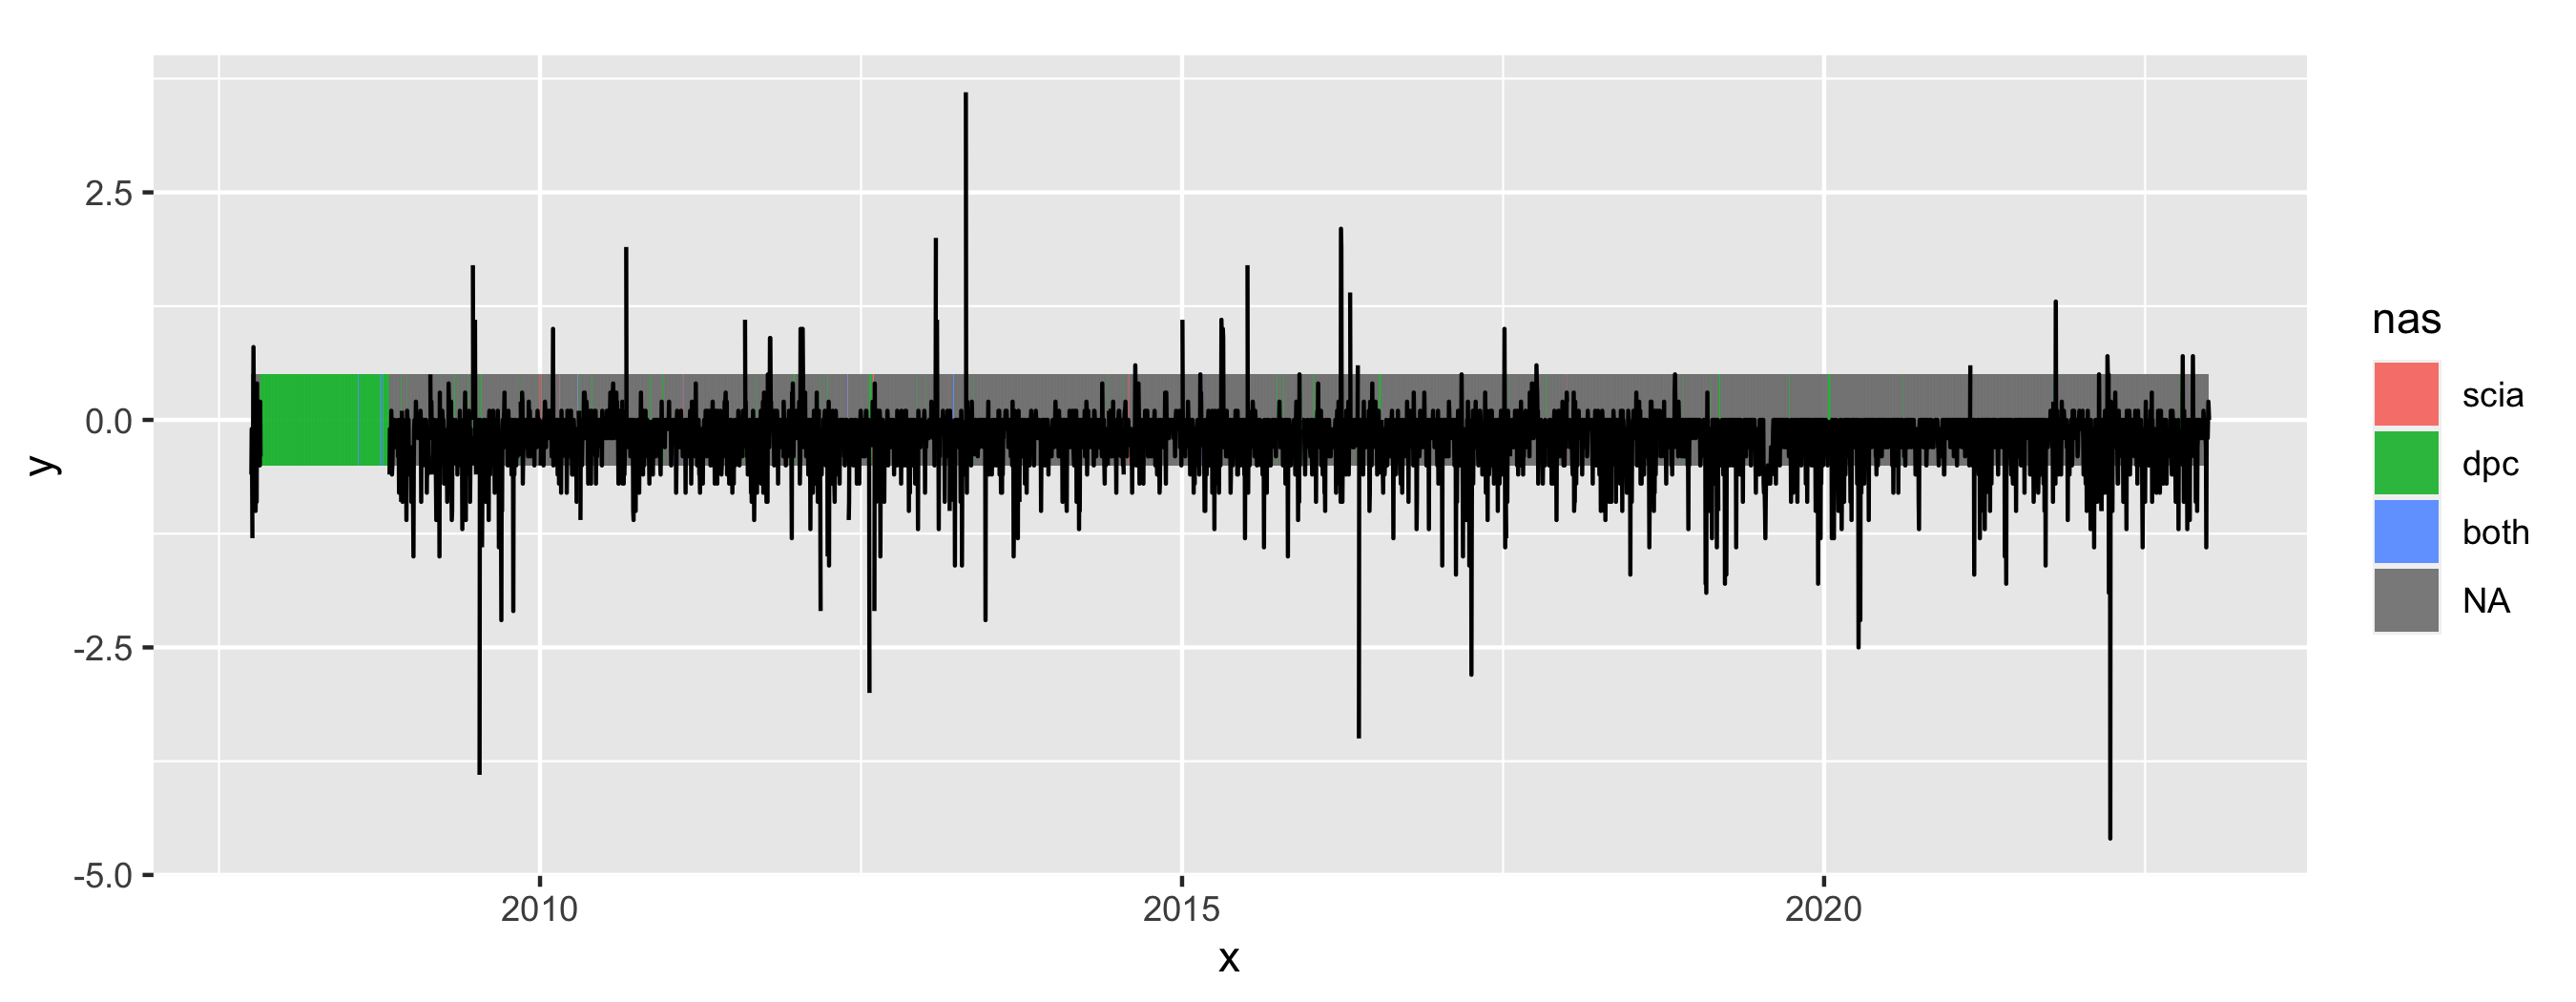

In [41]:
options(repr.plot.height = 3.5)
plot.sciavsdpc("T_MIN", 5796, "TN_VEN_RO_SANT_APOLLINARE_CMT_02_000493900", "qc_era5")


In [63]:
training_set |>
    filter(class == "good") |>
    group_by(identifier.x) |>
    slice_min(delT) |>
    sensible_columns() |>
    filter(strSym < 0.6)

variable,identifier.x,anagrafica.x,anagrafica.y,version,distance,strSym,f0,fsemiside,delH,delZ,delT,sdT,corT,climatdelT,climatsdT,overlap,minilap,valid_days_both
<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
T_MIN,5482,Vivaro,BASALDELLA_DI_VIVARO,2,2008.2264688,0.4074074,0.050709067,0.5403954,7,3.2557831,0.655199832,0.55727014,0.9931737,0.24124873,0.10884302,0.94232114,0.9952951,4654
T_MIN,5623,PIAMPRATO,VALPRATO_PIAMPRATO,2,288.9035574,0.5631808,0.498218202,0.5282346,8,17.3930664,0.159292759,0.27165624,0.9990241,0.20094247,0.09081393,0.85026800,0.9752707,7296
T_MAX,5631,PRERICHARD,BARDONECCHIA_PRERIC,2,768.0509000,0.5814815,0.567068843,0.9867991,272,226.1595459,0.139460606,0.25112748,0.9994752,0.14166892,0.11875413,0.82288511,0.9290518,7045
T_MIN,5691,Campo di Zoldo,FORNO_DI_ZOLDO_CAMPO,NA,80.9842460,0.5665850,1.000000000,1.0000000,0,0.0000000,0.000000000,0.00000000,1.0000000,0.06258606,0.04414724,0.91051037,0.9997344,7529
T_MAX,5691,Campo di Zoldo,FORNO_DI_ZOLDO_CAMPO,NA,80.9842460,0.5665850,1.000000000,1.0000000,0,0.0000000,0.000000000,0.00000000,1.0000000,0.08020044,0.06576317,0.90293638,0.9997321,7464
T_MIN,5797,San Martino d' Alpago,FUNES_BOVOLENTA,2,1640.5429970,0.4705882,0.071681912,0.8224753,110,95.5097046,0.451782711,0.32961705,0.9977130,0.35020029,0.21354954,0.64705197,0.9907527,5357
T_MAX,5816,Diga del Brugneto,BRUGNETO_DIGA,2,684.6856889,0.4500000,0.215423303,0.5456832,0,4.1354370,0.201341127,0.23210783,0.9993100,0.67545403,0.36308033,0.61570729,0.7990623,1193
T_MIN,5897,Nasceto,SESTA_GODANO,2,78.8070548,0.5896104,0.088794926,0.8931172,0,0.0000000,0.301808786,0.34430656,0.9981141,0.16087549,0.06362496,0.87415521,0.9772727,4257
T_MAX,5920,Righi,GENOVA_CASTELLACCIO,2,130.6900327,0.4185185,0.007643885,0.9959532,19,0.0000000,0.819064759,0.42101332,0.9984711,0.48181378,0.26701088,0.73164763,0.8025983,2224


In [50]:
joined.pos |> filter(identifier.x == 36) |> sensible_columns()

variable,identifier.x,anagrafica.x,anagrafica.y,version,distance,strSym,f0,fsemiside,delH,delZ,delT,sdT,corT,climatdelT,climatsdT,overlap,minilap,valid_days_both
<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
T_MIN,36,Casola Canina,CASOLA_CANINA,2,27.65017,1.0000000,0.12686567,0.8681592,-4,-1.901814,0.4169154,0.4185385,0.9985014,1.0685666,0.8353313,0.9031694,0.9877150,402
T_MIN,36,Casola Canina,SASSO_MORELLI,1,91.75489,0.5444444,NaN,NaN,-4,-1.901814,NaN,NA,NA,0.9746647,0.6877341,0.1532277,0.0000000,0
T_MAX,36,Casola Canina,CASOLA_CANINA,2,27.65017,1.0000000,0.07518797,1.0000000,-4,-1.901814,0.4060151,0.3529686,0.9994408,1.3844059,1.0510863,0.9028199,0.9876238,399
T_MAX,36,Casola Canina,SASSO_MORELLI,1,91.75489,0.5444444,NaN,NaN,-4,-1.901814,NaN,NA,NA,0.7874103,0.6289787,0.1522955,0.0000000,0
